# Visualizing Overlap Between Recovered CFGs



In [177]:
import os
import sys
import re
from pathlib import Path
from glob import glob
from os.path import *

from IPython.display import display
import dill
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns

tableau10raw = {
    "blue"   :(80, 122, 166), 
    "orange" :(240, 142, 57), 
    "red"    :(223, 88, 92),  
    "cyan"   :(120, 183, 178),
    "green"  :(91, 160, 83),  
    "yellow" :(236, 200, 84), 
    "purple" :(175, 123, 161),
    "pink"   :(253, 158, 169),
    "brown"  :(156, 117, 97), 
    "grey"   :(186, 176, 172) 
}

tableau10 = {k:'#%02x%02x%02x' % (v[0], v[1], v[2]) for k, v in tableau10raw.items()}

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette=tableau10.values())

sns.color_palette()
# rcParams['font.family'] = "Arial Rounded MT Bold"

[(0.3137254901960784, 0.47843137254901963, 0.6509803921568628),
 (0.9411764705882353, 0.5568627450980392, 0.2235294117647059),
 (0.8745098039215686, 0.34509803921568627, 0.3607843137254902),
 (0.47058823529411764, 0.7176470588235294, 0.6980392156862745),
 (0.3568627450980392, 0.6274509803921569, 0.3254901960784314),
 (0.9254901960784314, 0.7843137254901961, 0.32941176470588235),
 (0.6862745098039216, 0.4823529411764706, 0.6313725490196078),
 (0.9921568627450981, 0.6196078431372549, 0.6627450980392157),
 (0.611764705882353, 0.4588235294117647, 0.3803921568627451),
 (0.7294117647058823, 0.6901960784313725, 0.6745098039215687)]

In [28]:
import matplotlib as mpl
mpl.get_cachedir()

'/Users/rtsang/.matplotlib'

## Load all the CFGs

In [8]:
CFG_FN_PTRN = re.compile(r"(?P<fw>\w+)-(?P<opt>o[0123])-(?P<engine>\w+)-cfg\.pkl")

SRC_DIR = "../tests/cfgs"
OUT_DIR = "img"

pklpaths = glob(f"{SRC_DIR}/*.pkl")

graphs = {}
engs = []
# load all the generated graphs
for path in pklpaths:
    # should always match the filename
    match = CFG_FN_PTRN.search(basename(path))

    fw  = match.group('fw')
    opt = match.group('opt')
    eng = match.group('engine')
    engs.append(eng)

    with open(path, 'rb') as pklfile:
        graph = dill.load(pklfile)

    if fw not in graphs:
        graphs[fw] = {}
    if eng not in graphs[fw]:
        graphs[fw][eng] = {}
    graphs[fw][eng][opt] = graph

if not exists(OUT_DIR):
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    


In [137]:

def plot_comparison(graphs, other, title=None):
    sns.set_style('white')

    rcParams.update({
        'font.family': 'Arial Rounded MT Bold',
        'axes.unicode_minus': False
    })
    
    if not title:
        title = f"ffxe-vs-{other}"

    fw_labels = list(graphs.keys())
    fw_label_locs = np.arange(len(fw_labels))
    bar_width = 0.2

    # ax0 for graph node comparison
    opts = [f"o{i}" for i in range(4)]
    ffxe_opts = { k: { o:[] for o in opts } for k in ['nodes', 'edges'] }
    othr_opts = { k: { o:[] for o in opts } for k in ['nodes', 'edges'] }
    ovlp_opts = { k: { o:[] for o in opts } for k in ['nodes', 'edges'] }
    for fw in graphs.keys():
        for opt in opts:
            # get graphs to compare
            ffxe_cfg = graphs[fw]['ffxe'][opt]
            othr_cfg = graphs[fw][other][opt]

            # comput node overlaps
            for k in ['nodes', 'edges']:
                ovlp = ffxe_cfg[k].intersection(othr_cfg[k])
                ffxe_only = ffxe_cfg[k].difference(ovlp)
                othr_only = othr_cfg[k].difference(ovlp)

                ffxe_opts[k][opt].append(len(ffxe_only))
                othr_opts[k][opt].append(len(othr_only))
                ovlp_opts[k][opt].append(len(ovlp))

    for k in ['nodes', 'edges']:
        for opt in opts:
            ffxe_opts[k][opt] = np.array(ffxe_opts[k][opt])
            ovlp_opts[k][opt] = np.array(ovlp_opts[k][opt])
            othr_opts[k][opt] = np.array(othr_opts[k][opt])

    fig, (ax0, ax1) = plt.subplots(
        nrows=1, 
        ncols=2, 
        sharey=True,
        figsize=(12,8))

    fig.gca().use_sticky_edges = False

    sublabel_positions = []

    for k, ax in zip(('nodes', 'edges'), (ax0, ax1)):
        ax.xaxis.set_major_locator(ticker.MaxNLocator(symmetric=True))

        ffxe_rects = {}
        ovlp_rects = {}
        othr_rects = {}
        # offsets = [3, 1, -1, -3]
        offsets = [0, -2, -4, -6]
        # offsets = [-6, -4, -2, 0]
        max_width = 0
        down_shift = 0.1
        for opt, offset in zip(opts, offsets):
            total_widths = ffxe_opts[k][opt] + ovlp_opts[k][opt] + othr_opts[k][opt]
            max_width = max(max_width, max(total_widths))
            left_shift = -ovlp_opts[k][opt] / 2
            ffxe_rects[opt] = ax.barh(
                fw_label_locs + (bar_width * offset / 2) - down_shift, 
                ffxe_opts[k][opt],
                height=-bar_width,
                color=tableau10['blue'],
                left=(left_shift - ffxe_opts[k][opt]),
                align='edge'
            )
            # add annotations
            for bar in ffxe_rects[opt]:
                ax.text(
                    bar.get_x(),
                    bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                    round(bar.get_width()),
                    va='center',
                    ha='right',
                    size=10
                )
            ovlp_rects[opt] = ax.barh(
                fw_label_locs + (bar_width * offset / 2) - down_shift, 
                ovlp_opts[k][opt], 
                height=-bar_width,
                color=tableau10['purple'],
                left=(left_shift),
                align='edge'
            )
            for bar in ovlp_rects[opt]:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                    round(bar.get_width()),
                    va='center',
                    ha='center',
                    color='w',
                    size=10
                )
            othr_rects[opt] = ax.barh(
                fw_label_locs + (bar_width * offset / 2) - down_shift, 
                othr_opts[k][opt], 
                height=-bar_width,
                color=tableau10['red'],
                left=(left_shift + ovlp_opts[k][opt]),
                align='edge'
            )
            for bar in othr_rects[opt]:
                ax.text(
                    bar.get_x() + bar.get_width(),
                    bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                    round(bar.get_width()),
                    va='center',
                    ha='left',
                    size=10
                )
            if k == 'nodes':
                for bar in ffxe_rects[opt]:
                    bar_center = (bar.get_y() + bar.get_height() / 2)
                    sublabel_positions.append(bar_center)


        ax.set_title(k)

        # hide plot borders
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.yaxis.grid(True) # turn on horizontal grid lines
        ax.xaxis.set_visible(False) # hide x axis labels
        (llim, rlim) = ax.get_xlim()
        ax.set_xlim(left=(llim - 200), right=(rlim + 200))

        if k == 'nodes':
            ax.set_ylabel('Samples')

            # set major y labels
            ax.set_yticks(fw_label_locs, fw_labels,
                # verticalalignment='center',
                rotation=45)
            # add optimization labels
            sublabels = ['-' + opt for opt in opts for fw in graphs.keys()]
            ax.set_yticks(sublabel_positions, sublabels, minor=True)

            ax.tick_params(axis='y', which='major', pad=25) # spacing between y axis and major labels 
            # ax.tick_params(axis='y', which='major', left=False)

    fig.suptitle(title, x=0.55)
    fig.tight_layout()
    fig.canvas.draw()
    fig.savefig(f"{title}.svg", transparent=True, format='svg')

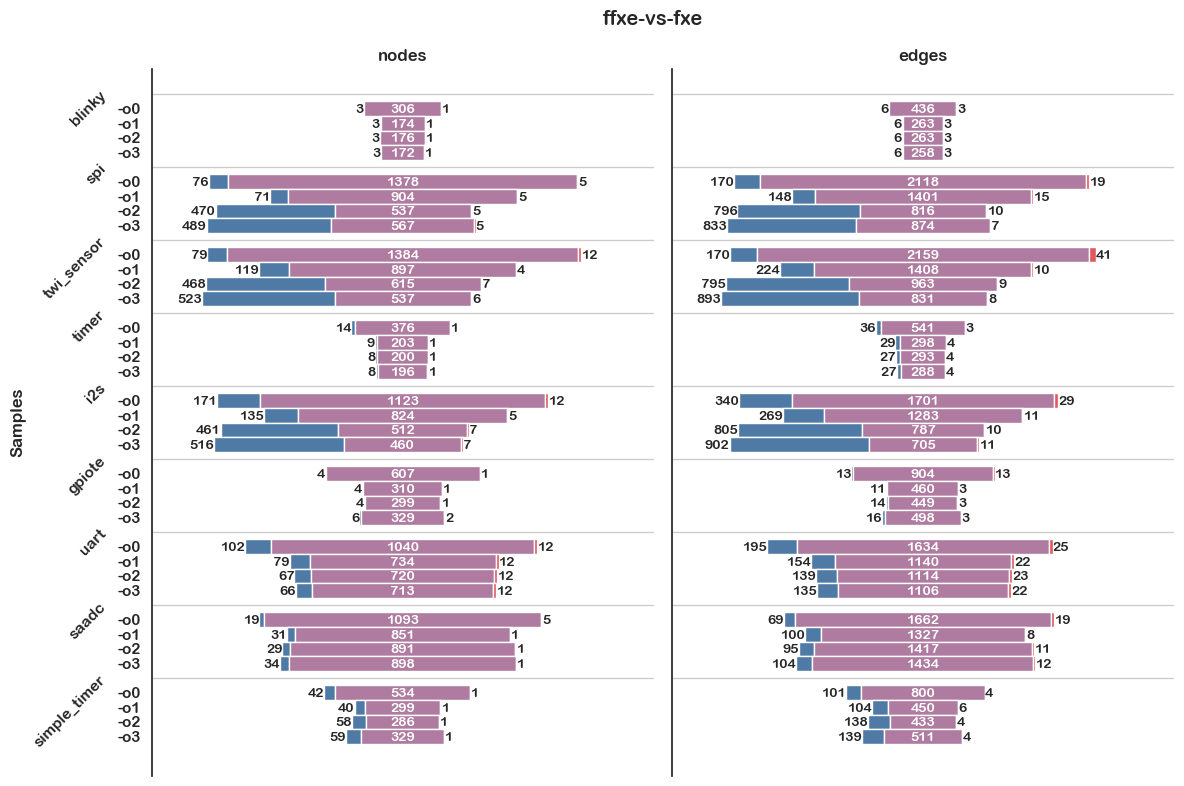

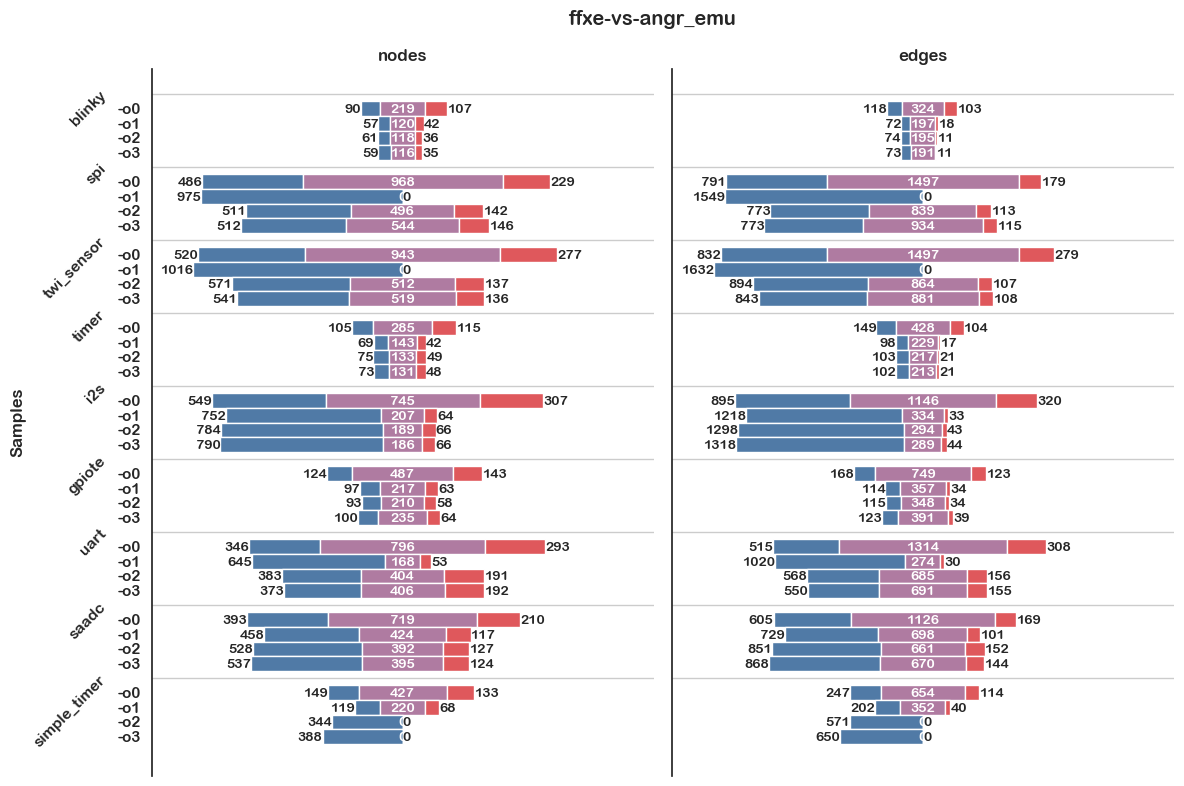

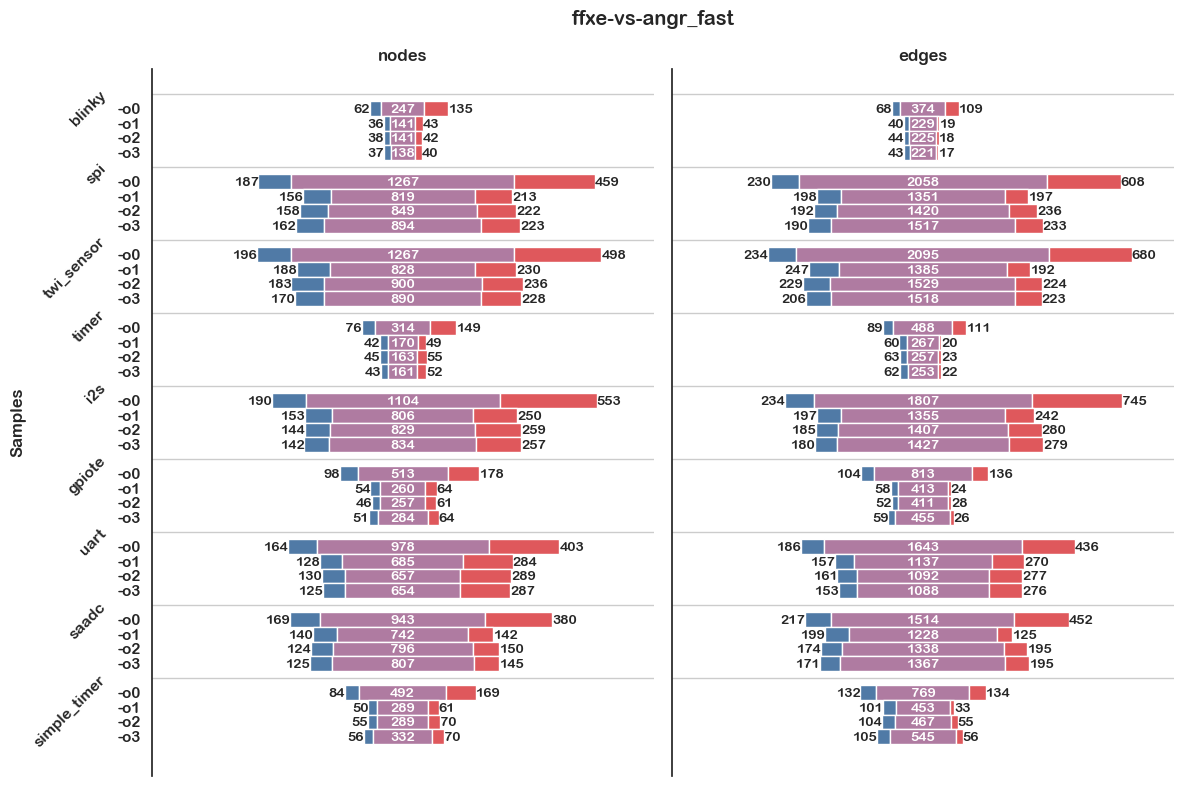

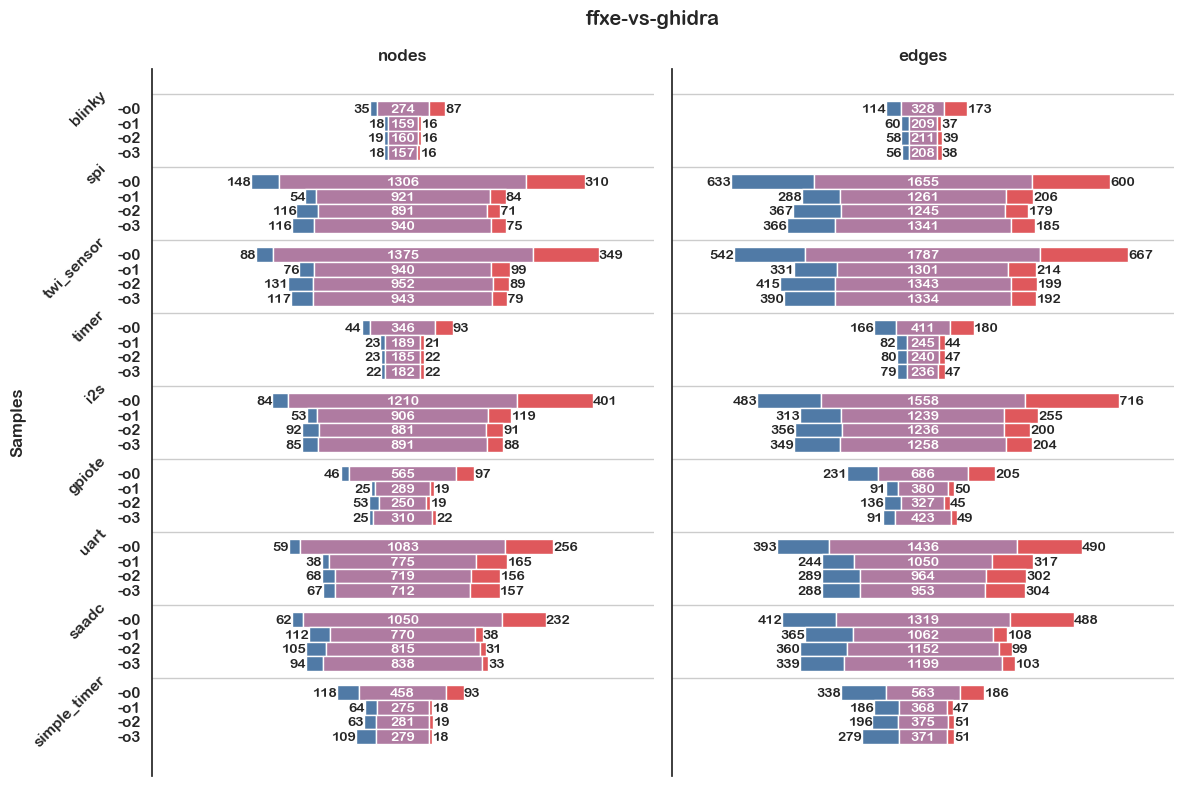

In [142]:
for eng in ['fxe', 'angr_emu', 'angr_fast', 'ghidra']:
    plot_comparison(graphs, other=eng)

In [203]:
def get_ovlp_data(graphs, engine, settype):
    """a helper function to get intersection data"""
    opts = [f"o{i}" for i in range(4)]
    ffxe_opts = { o:[] for o in opts }
    ovlp_opts = { o:[] for o in opts }
    othr_opts = { o:[] for o in opts }
    for fw in sorted(graphs.keys(), reverse=True):
        for opt in opts:
            # get graphs to compare
            ffxe_cfg = graphs[fw]['ffxe'][opt]
            othr_cfg = graphs[fw][engine][opt]
            
            # compute overlaps
            ovlp = ffxe_cfg[settype].intersection(othr_cfg[settype])
            ffxe_only = ffxe_cfg[settype].difference(ovlp)
            othr_only = othr_cfg[settype].difference(ovlp)
            
            ffxe_opts[opt].append(len(ffxe_only))
            othr_opts[opt].append(len(othr_only))
            ovlp_opts[opt].append(len(ovlp))
    
    for opt in opts:
        ffxe_opts[opt] = np.array(ffxe_opts[opt])
        ovlp_opts[opt] = np.array(ovlp_opts[opt])
        othr_opts[opt] = np.array(othr_opts[opt])
    
    ovlp_data = [ ('ffxe', ffxe_opts), ('ovlp', ovlp_opts), (engine, othr_opts) ]
    return ovlp_data

def make_ovlp_subplot(ax, ovlp_data, getsublabels=False):
    """helper function to plot horizontal bar chart subplots"""
    
    # set up symmetrix x axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(symmetric=True))
    
    # setup data
    opts = [f"o{i}" for i in range(4)]
    engine = ovlp_data[-1][0]
    ovlp_data = dict(ovlp_data)
    ffxe_opts = ovlp_data['ffxe']
    ovlp_opts = ovlp_data['ovlp']
    othr_opts = ovlp_data[engine]

    sublabels = []
    ffxe_rects = {}
    ovlp_rects = {}
    othr_rects = {}
    # offsets = [3, 1, -1, -3] # fw name in center of opts
    offsets = [0, -2, -4, -6] # o0 aligned with fw name
    # offsets = [-6, -4, -2, 0] # 03 aligned with fw name
    down_shift = 0.1 # adding space between bars and grid lines
    annotate_size = 9 # fontsize of annotation
    for opt, offset in zip(opts, offsets):
        # left shift to center bars
        left_shift = -ovlp_opts[opt] / 2
        
        ffxe_rects[opt] = ax.barh(
            fw_label_locs + (bar_width * offset / 2) - down_shift, 
            ffxe_opts[opt],
            height=-bar_width,
            color=tableau10['blue'],
            left=(left_shift - ffxe_opts[opt]),
            align='edge'
        )
        # add annotations to left
        for bar in ffxe_rects[opt]:
            ax.text(
                bar.get_x(),
                bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                round(bar.get_width()),
                va='center',
                ha='right',
                size=annotate_size
            )
        ovlp_rects[opt] = ax.barh(
            fw_label_locs + (bar_width * offset / 2) - down_shift, 
            ovlp_opts[opt], 
            height=-bar_width,
            color=tableau10['purple'],
            left=(left_shift),
            align='edge'
        )
        # add annotations centered
        for bar in ovlp_rects[opt]:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                round(bar.get_width()),
                va='center',
                ha='center',
                # color=tableau10['yellow'],
                color='w',
                size=annotate_size
            )
        othr_rects[opt] = ax.barh(
            fw_label_locs + (bar_width * offset / 2) - down_shift, 
            othr_opts[opt], 
            height=-bar_width,
            color=tableau10['red'],
            left=(left_shift + ovlp_opts[opt]),
            align='edge'
        )
        # add annotations to right
        for bar in othr_rects[opt]:
            ax.text(
                bar.get_x() + bar.get_width(),
                bar.get_y() + bar.get_height() / 2 - 0.02, # center text in bar
                round(bar.get_width()),
                va='center',
                ha='left',
                size=annotate_size
            )
        
        if getsublabels:
            for bar in ffxe_rects[opt]:
                bar_center = (bar.get_y() + bar.get_height() / 2)
                sublabels.append((opt, bar_center))
                
    return np.array(sublabels).T



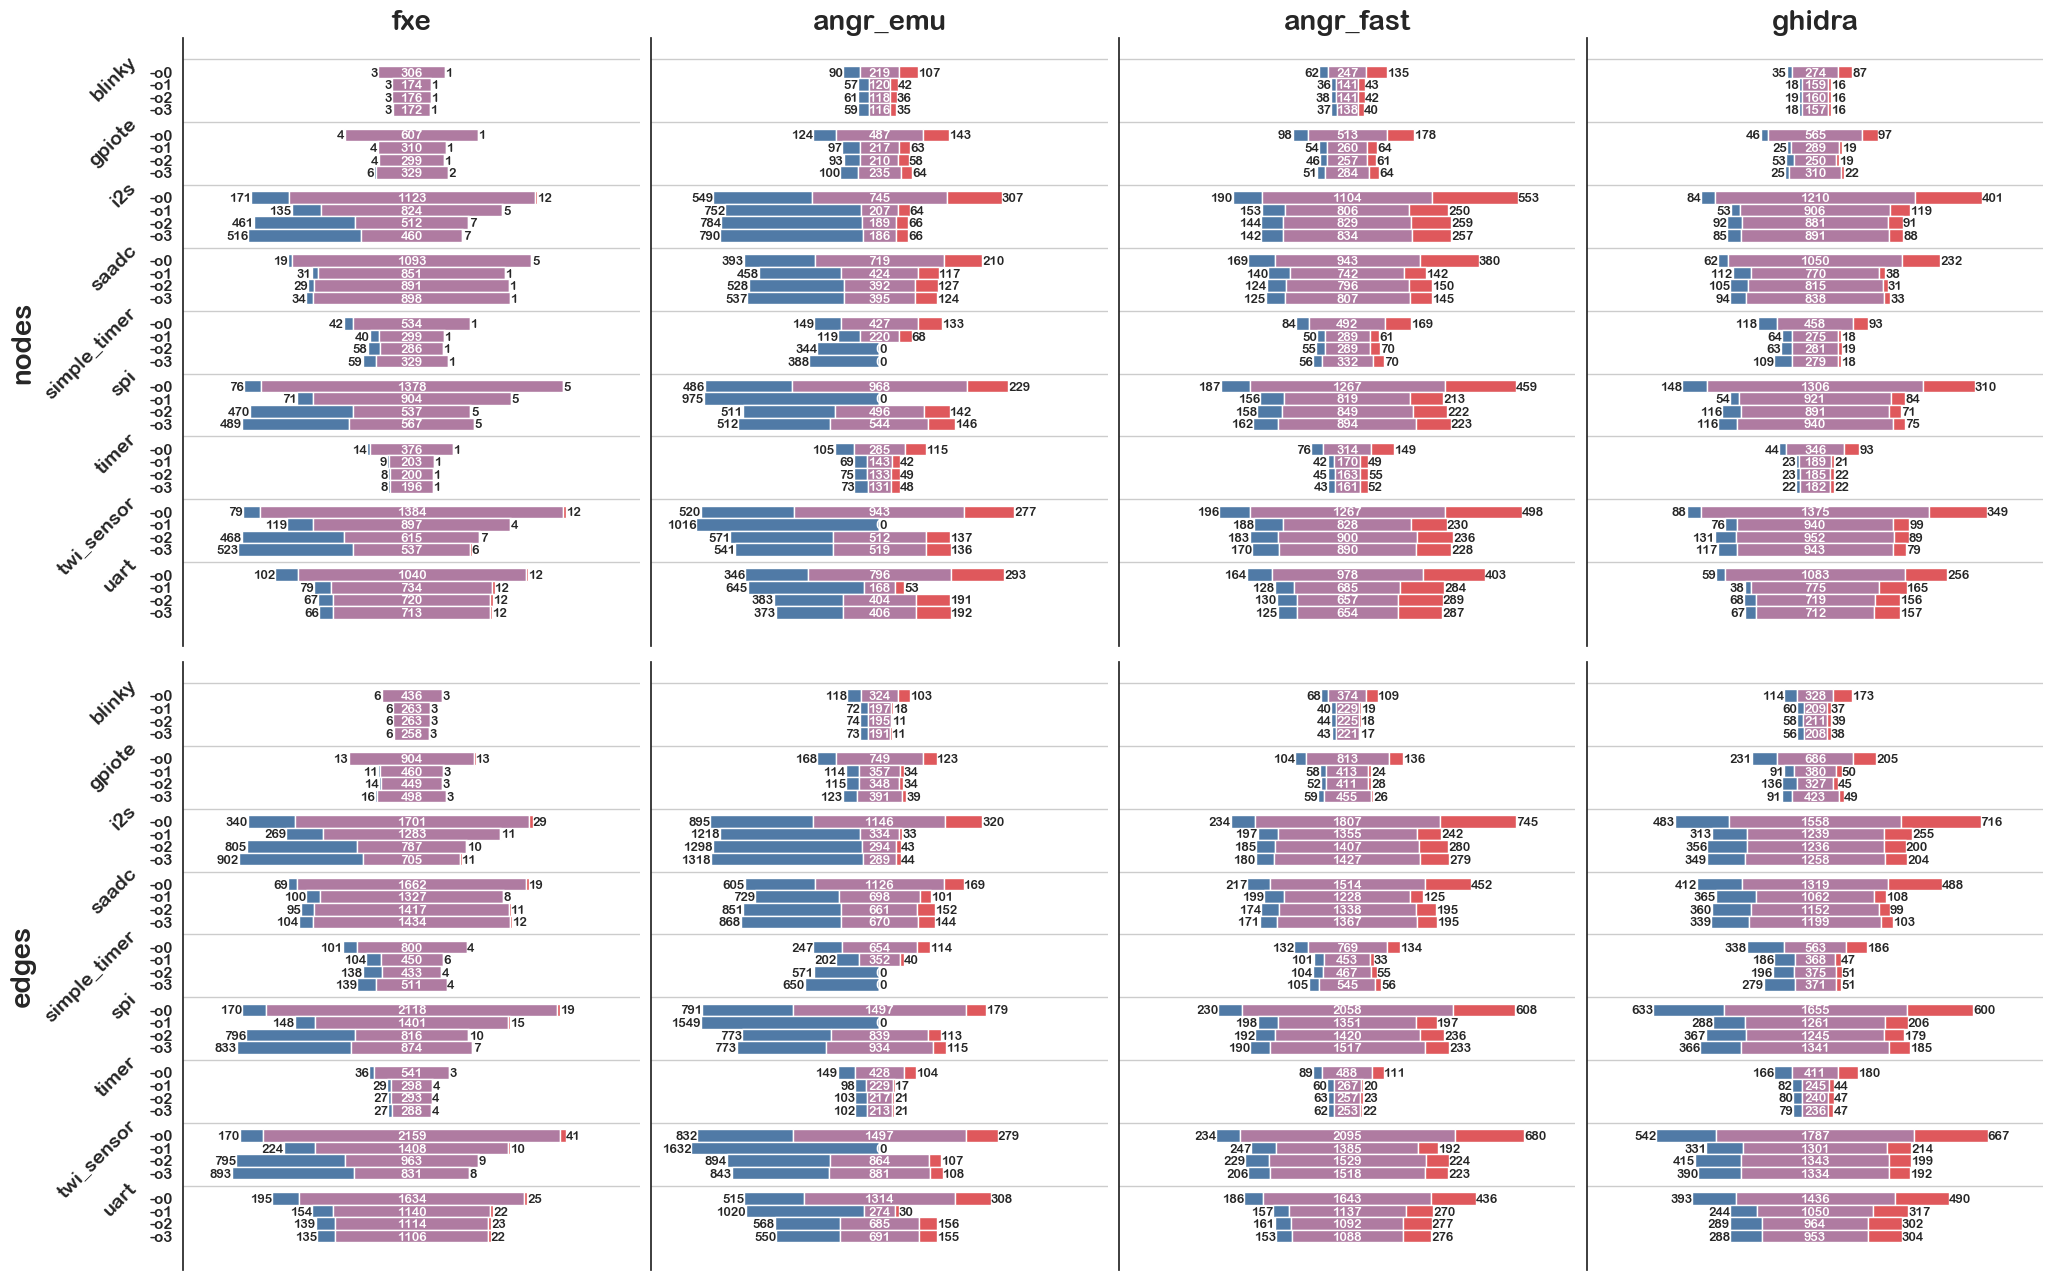

In [204]:
sns.set_style('white')
rcParams.update({
    'font.family': 'Arial Rounded MT Bold',
    'axes.unicode_minus': False
})

fw_labels = list(sorted(graphs.keys(), reverse=True))
fw_label_locs = np.arange(len(fw_labels))
bar_width = 0.2

fig, (nodes_ax, edges_ax) = plt.subplots(
    nrows=2, 
    ncols=4, 
    sharey=True,
    figsize=(24,16),
    gridspec_kw={
        'wspace': 0.025, 
        'hspace': 0.025
    }
)

# don't align bars with y axis
fig.gca().use_sticky_edges = False
engs = ['fxe', 'angr_emu', 'angr_fast', 'ghidra']

for settype, axs in zip(['nodes', 'edges'], (nodes_ax, edges_ax)):
    for eng, ax in zip(engs, axs):
        ovlp_data = get_ovlp_data(graphs, eng, settype)
        
        sublabels = make_ovlp_subplot(ax, ovlp_data, getsublabels=(eng == 'fxe'))
        
        if settype == 'nodes':
            ax.set_title(eng,
                fontsize=20)
        
        # hide plot borders
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.yaxis.grid(True) # turn on horizontal grid lines
        ax.xaxis.set_visible(False) # hide x axis labels
        
        # add edge space
        space = 250
        if settype == 'edges':
            space = 350
        (llim, rlim) = ax.get_xlim()
        ax.set_xlim(left=(llim - space), right=(rlim + space))
        
        if sublabels.size:
            ax.set_ylabel(settype,
                fontsize=20)

            # set major y labels
            ax.set_yticks(fw_label_locs, fw_labels,
                # verticalalignment='center',
                rotation=45,
                fontsize=14)
            # add optimization labels
            locs = list(sublabels[1].astype(float))
            text = list(sublabels[0])
            text = ['-' + t for t in text]
            ax.set_yticks(locs, text, minor=True)

            ax.tick_params(axis='y', which='major', pad=25) # spacing between y axis and major labels 
            ax.tick_params(axis='y', which='major', left=False)

# fig.tight_layout()
fig.canvas.draw()

## Helpful Links

### Official Docs

- [demo stacked bars](https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html)
- [demo horizontal bars](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)
- [barh api](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html)
- [demo shared axis](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/shared_axis_demo.html)
- [demo multiple subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplot.html)
- [demo plt.subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)
- [plt.subplots api](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots)
- [set_yticks api](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yticks.html)
- [Text api (for label kwargs)](https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text)
- [suptitle api](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html)

### StackOverflow

- [centering horizontal bars](https://stackoverflow.com/questions/61547017/)
- [changing fonts](https://stackoverflow.com/questions/21321670/)
- [changing global fonts](https://stackoverflow.com/questions/21461155/)
- [symmetric axes](https://stackoverflow.com/questions/20519241/)
- [hiding axis](https://stackoverflow.com/questions/2176424/)
- [removing borders](https://stackoverflow.com/questions/14908576/)
- [adding sublabels](https://stackoverflow.com/questions/73365779/)
- [saving svg](https://stackoverflow.com/questions/24525111/)

### Other

- [stacked bar labels](https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/)
- [fig.canvas.draw](https://www.geeksforgeeks.org/matplotlib-figure-figure-draw-in-python/)
